## UNET

In [30]:
!pip install fastai --upgrade > /dev/null

featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


In [0]:
from fastai.utils.collect_env import *
show_install(True)

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

In [35]:
path_lr

PosixPath('/content/data/oxford-iiit-pet/crappy')

Data Augmentation and Crappify Function: It defines a crappifier class that takes high-resolution images and generates corresponding low-resolution, degraded images. This simulates the super-resolution problem, where the task is to generate high-quality images from low-quality inputs.

In [0]:

from crappify import *

def crappify(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    w,h = img.size
    q = random.randint(10,70)
    ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
    img.save(dest, quality=q)


In [0]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [51]:
il = ImageList.from_folder(path_hr)
il
parallel(crappifier(path_lr, path_hr), il.items)

keeshond_20.jpg


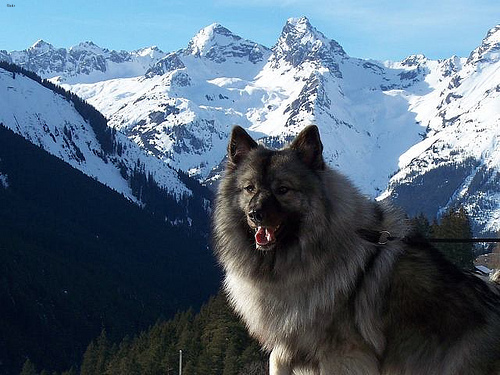

In [54]:
import os, random
from PIL import Image

a=random.choice(os.listdir(path/'images'))
print(a)

file = os.path.join(path/'images',a)
img = Image.open(file)
img

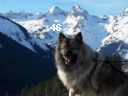

In [55]:
file = os.path.join(path/'crappy',a)
img = Image.open(file)
img

In [0]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

### U-Net with per-pixel MSE Loss

Model Training: It defines a generator model architecture (a U-Net with ResNet34 backbone), sets up the data for training, and trains the model.

In [0]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)

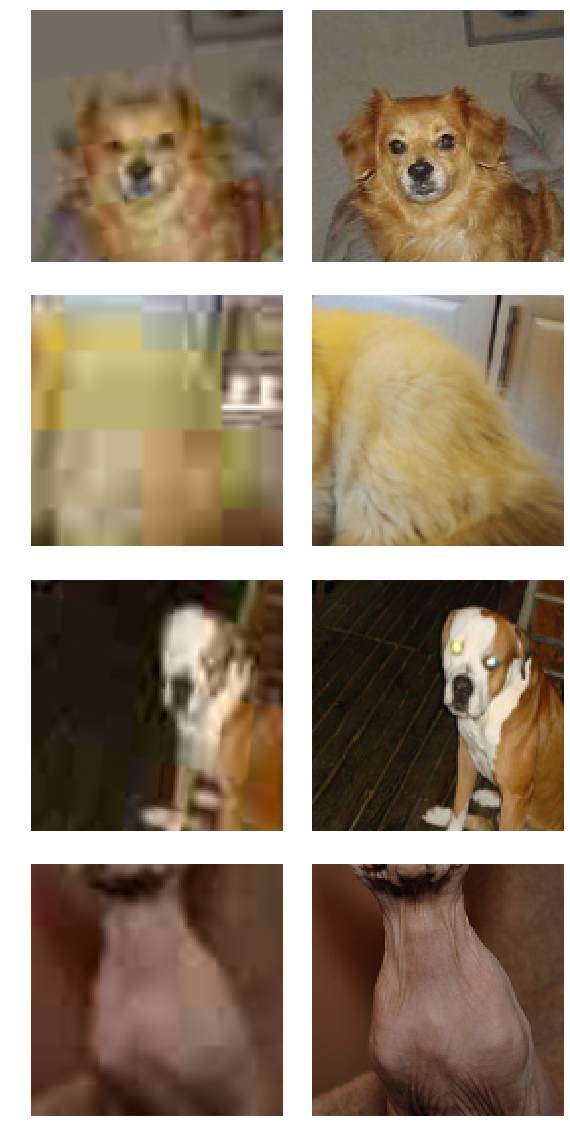

In [60]:
data_gen.show_batch(4)

In [0]:
wd = 1e-3

In [0]:
y_range = (-3.,3.)

As loss function, we use Mean Square Error (MSE) 
* calculates the  the average MSE between the pixel value predicted and the actual pixel value. 
* MSELoss takes 2 vectors; `MSELossFlat()` flattens out those images


In [0]:
loss_gen = MSELossFlat()

In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

Train the model
* in fastai library learner does transfer learning by default, so when creating it, it'll freeze the pre-trained part. 
* In the case of a U-net, the pre-trained part is the left side of the U.  


In [66]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 99625972.77it/s]


In [67]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

Unfreeze and train more:

In [0]:
learn_gen.unfreeze()

In [69]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

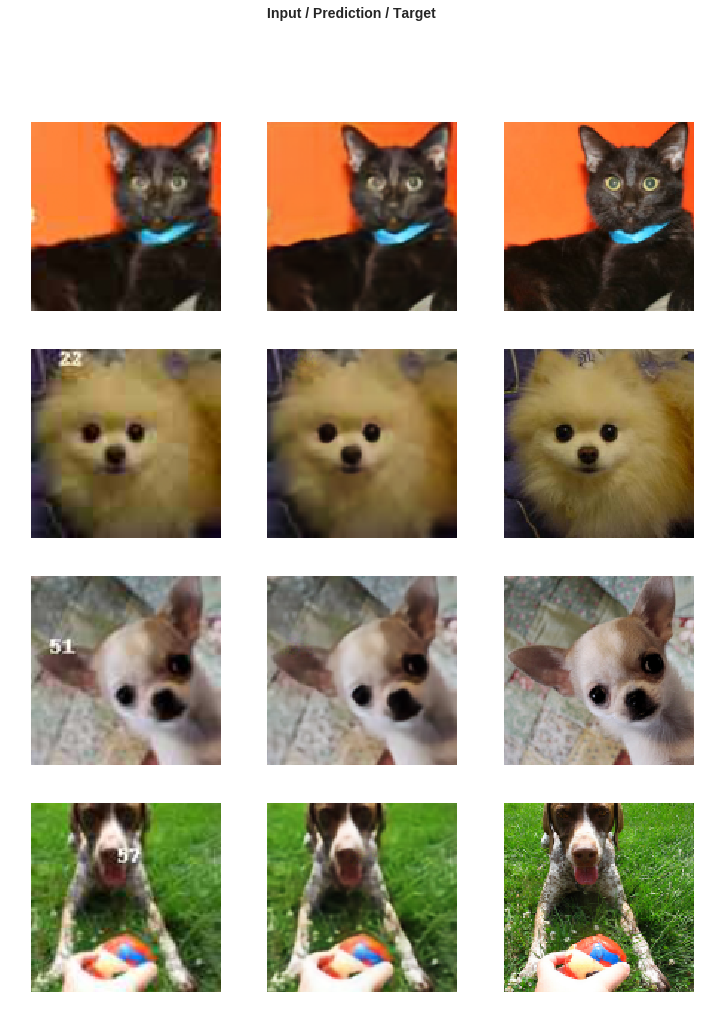

In [70]:
learn_gen.show_results(rows=4)

## SRGANs




define `get_crit_data()` to implement a standard image classifier that predicts whether an image is real/hi-res or generated/crappy. 


In [0]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [0]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

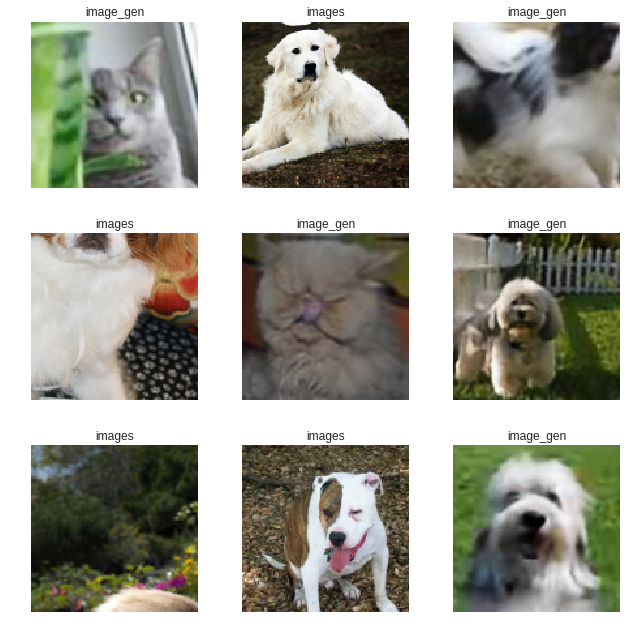

In [86]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

### Loss function
As loss function we use Binary Cross-Entropy:


In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

Create the critic learner.

* In Fast.ai using `gan_critic()` as model will provide you with a binary classifier suitable for GANs. 
* the gan_critic() uses a different way of averaging the different parts of the image when using the loss. That's why we use the AdaptiveLoss function to wrap the Binary Cross-Entropy Loss. 
* We also use a different metric: accuracy_thresh_expand



In [0]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

Train the Critic

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [90]:
learn_critic.fit_one_cycle(6, 1e-3)

In [0]:
# Save the model
learn_critic.save('critic-pre2')

### Build the GAN Learner

We now have the pre-trained Generator and the pre-trained Critic. We'll combine both in a GAN and do a little bit of ping-pong between both. 

In [93]:
learn_crit=None
learn_gen=None
gc.collect()

15785

Critic Databunch and Training:

The get_crit_data function creates a databunch for training the critic model. It includes both generated images (name_gen) and real images ('images').
The critic model is trained using binary cross-entropy loss (nn.BCEWithLogitsLoss) for 6 cycles.

In [0]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [0]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner:
- specify the learner objects for the generator and the critic. 
- The switcher is a callback that decides when to switch from discriminator to generator and vice versa. 
- Here we do as many iterations of the discriminator as needed to get its** loss back < 0.5** then 1 iteration of the generator.
- The **loss of the critic** is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 
- The **loss of the generator** is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)

learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)

learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

Fit the model

In [0]:
lr = 1e-4

In [99]:
learn.fit(20,lr)

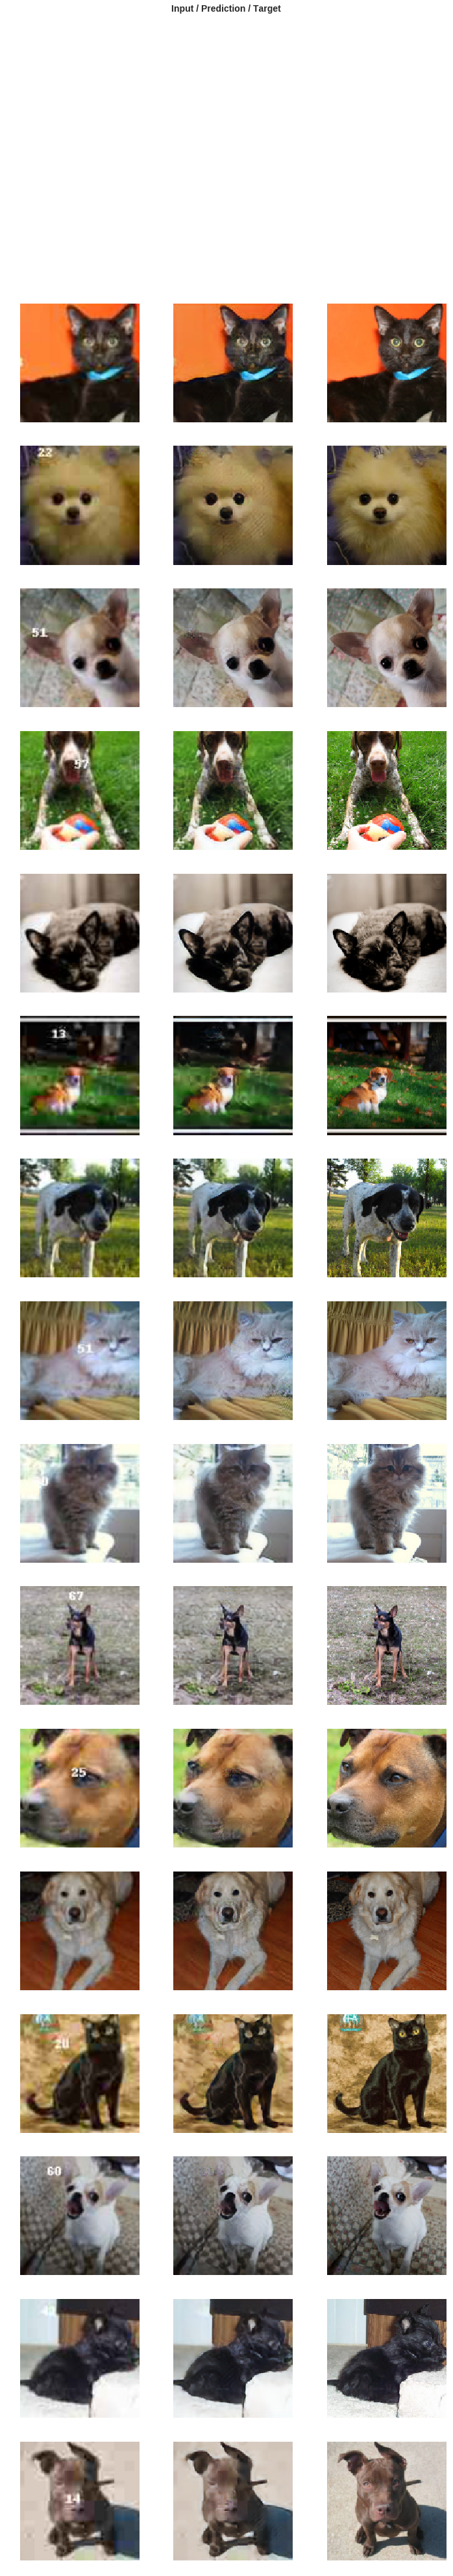

In [100]:
learn.show_results(rows=16)